(explainer_community_detection)=
Community detection
==================

In [14]:
import time
import pickle
import pandas as pd
import community
import networkx as nx
from fa2 import ForceAtlas2
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from collections import Counter, namedtuple, defaultdict
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')  # Hide DeprecationWarning
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from matplotlib import rc
plt.style.use('science')
set_matplotlib_formats('svg')
rc("text", usetex=False)

from pyvis.network import Network
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import from_networkx
from bokeh import palettes
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.models import Title
output_notebook()

Loading BokehJS ...

In the [walk-through of our network's basic properties](explainer_basicstats) we see that nodes tend to bundle together in different groups. To identify some of these groups in a systematic way *community detection* serves as a useful tool. For this we use the *Louvain algorithm*. The Louvain algorithm relies on the network's *modularity* which is best described as a measure of how well a partitioned in the network can be split into supgraphs (communities). A higher modularity therefore corresponds to a better community structure. Formally the modularity can be expressed as {cite}`barabasi2016network`:

$$
M = \sum^{n_c}_{c=1}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^{2}\right]
$$

where $n_c$ are the communities, $L_c$ are the number of links and  $k_c$ the total degree of nodes in the community $c$. The Louvain algorithm tries to find the communities that maximize $M$ by the following two steps {cite}`barabasi2016network`:
1. First it assigns each node to its own communities, i.e. there are as many communities as nodes. Next, for each node $i$ we evaluate if by assigning it to one of its neighbours $j$ communities the change in modularity  $\Delta M$ is positive. Node $i$ then moves to the community of the neighbor that yields the highest positive change in $\Delta M$. This is repeated for all nodes until no further increase can be made.
2. In the second step, the algorithm creates a "super graph", that is each community is condensed into one node where the edges are now weighted by the total number of links going from one community to the other in the original network. Having done this, we rerun the first step on the "super graph". 

The steps are done iteratively until the maximum $M$ has been reached. As this is an approximate method it is not ensured that the algorithm will always find the global maximum $M$, all though that tests shows, that the algorithm usually is fairly accurate {cite}`findcommunities`.

To implement the Louvain algorithm and find the optimal communities for our network we simply rely on the function `.best_partition()` from the module `community`. As the Louvain algorithm only works for undirected networkx we model our network accordingly for the community detection. Furthermore we restrict our network to the giant connected component, as the Lovain algorithm else finds several communites consisting of 1 node. 

Once again we use the data from our [Data collection notebook](explainer_data_collection).

In [15]:
# We load in our final edgelist and model a undirected network
edgelist = pd.read_pickle('https://drive.google.com/uc?export=download&id=1e3sy-VzJQXP1CozdBviCD5PYgrcWC_dw')
node_attr = pd.read_pickle("https://drive.google.com/uc?export=download&id=1HvB-OQt4P-MXEM7X-fT47_aso9-KL_pK")
G = nx.Graph()
G.add_edges_from(edgelist) 
nx.set_node_attributes(G, node_attr)

# We extract the gcc
gcc = max(nx.connected_components(G), key=len)
G = G.subgraph(gcc)

#Get Louvain partitions and the distribution of communites
partition = community.best_partition(G, random_state = 1)  # Set seed for reproducibility
community_distribution = Counter(partition.values())

# Basic stats from the community detection
print(f'The Louvain algorithm found {len(set(partition.values()))} communities')
print(f'Largest community consists of {max(community_distribution.values())} nodes')
print(f'Smallest community consists of {min(community_distribution.values())} nodes')
print(f'Modularity of network: {np.round(community.modularity(partition,G), 4)}')
print(f'Mean community size {np.round(np.mean(list(community_distribution.values())),3)} nodes')

The Louvain algorithm found 24 communities
Largest community consists of 382 nodes
Smallest community consists of 4 nodes
Modularity of network: 0.623
Mean community size 110.375 nodes


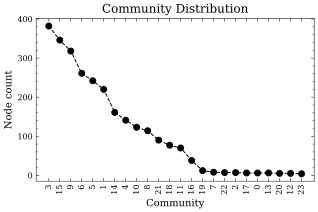

In [3]:
def plot_communities_nodes(c: Counter = community_distribution):
    """
    Function to plot the number of nodes for each community.
    """
    x = [str(x) for x,y in c.most_common()]
    y = [y for x,y in c.most_common()]
    fig, ax = plt.subplots(dpi = 150, figsize=(5,3))
    ax.plot(x, y, 'ko--')
    ax.set_title('Community Distribution')
    ax.set_ylabel('Node count')
    ax.set_xlabel('Community')
    ax.tick_params(axis='x', which='minor', bottom=False, top=False)
    ax.tick_params(axis='x', rotation=90)
    plt.xticks(size=8)
    plt.yticks(size=8)
    plt.show()

plot_communities_nodes()

Our Louvain-algorithm finds 24 communities. All though the overall modularity on *average* is fairly accurate {cite}`findcommunities` we must still be careful when interpreting the communites, as some of them are very small and might be prone to errors. For an example is the smallest community deteceted composed of only 4 nodes. We therefore decide to limit our further insecption of the communities to the 9 most frequent (9 instead of 10 for practical reasons when we want to vizualise the communites).

## TF-IDF

To decide what the resulting communities reflect we can list the most frequent words. However using the simple counts of each word would not reflect the differences between the communities, as this would yield a list of rather generic terms always occuring. Instead we want to see how import the words in one community are *relative* (or, simply TF-IDF) to other communities. For this end the *term frequency–inverse document frequency* is a relevant measure. Following the [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) documentation the TF-IDF can be defined as:

$$
\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}} * \log \frac{N}{|\{d \in D: t \in d\}|}
$$


where $f_{t,d}$ the simple count of times that a term, t, occurs in a document, d, why the first expression constitutes the Term-Frequency. In the other expression, the Inverse-document frequency, $N$ is total number of documents across all communities, and $\{d \in D: t \in d\}$ constitutes the number of communities where a term $t$ appears. As we base our TF_IDF on 9 documents with all of the tokens from the corresponding communities, a high value means that a term occur relative often in one community compared to the other communities.

Before create our Document-Feature-Matrix we load in the [preprocessed DataFrame from earlier](explainer_data_collection). We then create two self-explanatory columns to use for our TF-IDF: `unigrams` and `bigrams`. These are based on our lemmatized tokens.

In [4]:
df = pd.read_pickle('Final_df.pickle')

def get_bigrams(unigram: list) -> list:
    """
    Takes list of unigrams and converts them to bigrams
    """
    return["_".join([unigram[i], unigram[i+1]]) for i,t in enumerate(unigram) if i != len(unigram)-1]

df["unigrams"] = df["tokens"]
df["bigrams"] = df["unigrams"].apply(lambda x: get_bigrams(x))

Based on our list of unigrams and bigrams we can now create a document-feature-matrx for the 9 communities. As we have an extensive list of 1.277.090 tokens when we include unigrams and bigrams we somewhat arbitrarely decide that each term has to occur at least 5 times to be included in the final matrix. This yields 28.728 tokens.

In [5]:
def create_dfm(docs:List[List], min_df:int=1, 
               max_df:int=np.inf, idf:bool=True, 
               return_vocab=False)->np.array:
    """
    Creates document-feature matrix of size N (docs) x K (vocab size).
    args:
        docs(list[list]): a list of documents where a document is a list of tokens.
        max_df(int): maximum freq allowed for a token in a document
        min_df(int): minimum freq required for a token in a document
        idf(bool): calculate the iverse document frequency (idf) else raw count
    returns:
        dfm(np.array): the NxK dfm
        vocab(list): vocab of unique tokens
    """
    #Remove very common or uncommon words
    if min_df != 0 or max_df != np.inf:
        temp = []
        for doc in docs:
            word_freq = Counter(doc)
            temp.append([w for w in doc if word_freq[w] >= min_df and 
                                           word_freq[w] <= max_df])
        docs = temp
        
    #Build the vocabulary and create index for each token
    vocab = list(set([w for doc in docs for w in doc]))
    vocab_size = len(vocab)
    tok2idx = {w:i for i,w in enumerate(vocab)}
    doc_n = len(docs)
    
    #Instantiate the dfm and add counts
    dfm = np.zeros([doc_n, vocab_size])
    for i,toks in enumerate(docs):
        for tok in toks:
            tok_idx = tok2idx[tok]
            dfm[i, tok_idx] += 1
    
    #Calculate tf-idf
    if idf:
        dfm = dfm / dfm.sum(axis = 1)[:, None]
        idf = np.sign(dfm)
        for i in range(doc_n):
            idf[i] = np.log((doc_n / idf.sum(axis = 0)))
        dfm *= idf
        
    if return_vocab:
        return dfm, vocab
    else:
        return dfm

#Add the corresponding community to each page in the DataFrame
communites = []
obs = namedtuple('Obs', 'name Louvain_Community')
for n in df['title']:
    try:
        com = 'community_'+str(partition[n])
    except:
        com = np.nan
    communites.append(obs(n, com))
df = pd.merge(df, pd.DataFrame(communites), left_on='title', right_on = 'name')

#Get top9 communities
top9 = ['community_'+str(c[0]) for c in community_distribution.most_common(9)]

#Subset data on top9 communities and groupby community. Extract the unigrams and bigrams.
top9_df = df.loc[df['Louvain_Community']\
                  .isin(top9)].groupby('Louvain_Community')\
                  .agg({'unigrams':'sum',
                        'bigrams':'sum'})

# Token list with both unigrams and bigrams
tokens = top9_df.reset_index()["unigrams"] + top9_df.reset_index()["bigrams"]

#Create the document term frequency matrices for unigrams and bigrams. Token must appear min. 5 times
tf_idf, vocab = create_dfm(tokens, idf=True, return_vocab=True, min_df=5)

#Put into dataframes with vocab as colnames and community as index
tfidf_df = pd.DataFrame(tf_idf, columns=vocab, index = top9_df.index)

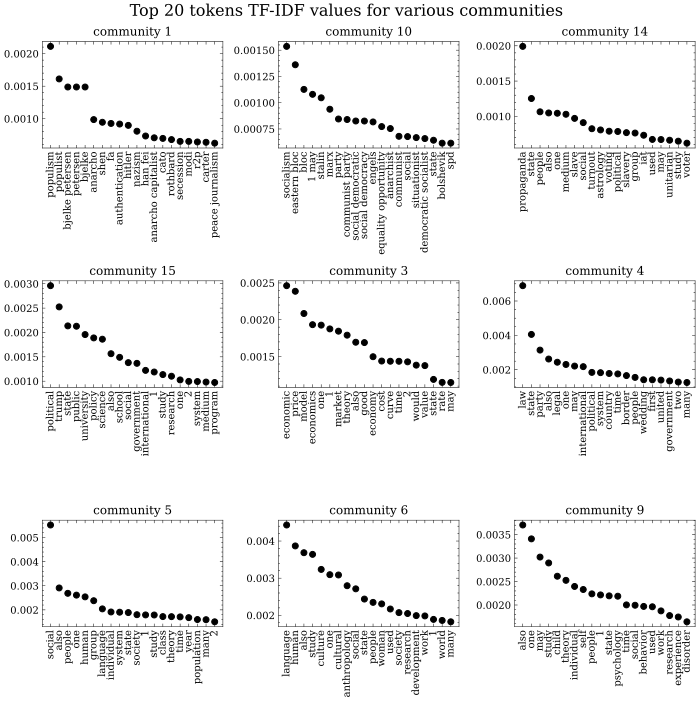

In [6]:
#Plot tf-idf
def plot_top_tfidf(df:pd.DataFrame=tfidf_df, n:int=20)->None:
    """
    Plots the n tokens with higest tf-idf score for the 6 most frequent communities
    """
    fig, axs = plt.subplots(nrows = 3, ncols=3, 
                            figsize = (10,10), dpi = 300)
    fig.suptitle("Top 20 tokens TF-IDF values for various communities", fontsize=16)
    
    axs = axs.flat
    for i, row in enumerate(df.iterrows()):
        d = row[1].nlargest(n).to_dict()
        x = [n.replace('_', ' ') for n in d.keys()]
        y = d.values()
        axs[i].plot(x,y, 'ko')
        axs[i].set_title(df.index[i].replace('_', ' '))
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].tick_params(axis='x', which='minor', bottom=False, top=False)
    plt.tight_layout()
    
plot_top_tfidf()

The TF-IDF values reveals some quite interesting attributes of the communities. As one would expect, there is some communities as 15, 3, 6 and 9 that clear relates to the disciplines political science, economics, anthropology and psycology. Non-surpringsly this suggets, that pages from the same Wikipedia category tend to cluster together. But on the other hand we also find communities like 1 and 10 that clearly describes pages refering to far-right/populistic and far-left/socialist pages, where the so-called ["*Hillbilly Dictator*" Joh Bjelke-Petersen](https://en.wikipedia.org/wiki/Joh_Bjelke-Petersen) is amongst the pages with a higest TF-IDF scores. Lastly community 14 is fairly interesting as it suggets that pseudoscientific pages such as [medium](https://en.wikipedia.org/wiki/Mediumship) and [atstrology](https://en.wikipedia.org/wiki/Astrology?wprov=srpw1_0) are placed in the neighbourhood of political repressive phenomas as state [propaganda](https://en.wikipedia.org/wiki/Propaganda) and [slavery](https://en.wikipedia.org/wiki/Slavery)

## Multinomial Logistic regression

Lastly, to get other nuances of these communities we implement a multinomial lasso-logistic regression with `sklearn`. The multinomial model closely resembles a regular logistic regression but is extended from binary classification to multi-class classification. We then extract each feature's *average marginal effects* (AME) to inspect how predictive they are of each community. Following {cite}`cameron2005microeconometrics` this can be expressed as:

$$
AME_{jk} = \frac{\partial Pr[y_i = j|\mathbf{w}_{i}]}{\partial w_{jk}} = N^{-1} \sum_{i = 1}^N p_{ij}\left(\theta_{jk} - \sum^J_{m = 1} p_{im} \theta_{mk}\right)
$$

where $\mathbf{w}_i$ is a vector of token frequencies for each community and ${\theta}_j$ is the estimated coefficient vector for each community of length equal to the vocabulary. This also means that we rely on the raw count of every token in each community rather than TF-IDF value to calculate the AME. We do this to ease the interpretability of the effects, as the AME then describe how the probability of a community changes as we increment the count of the given token. To get the raw count of our vocabulary we use our funtion `create_dfm()` from before but set the `idf` argument to `False`, hence we get the word counts. As before, we specify that a token have to occur at least five times in community to be part of a document-feature-matrix.

In [7]:
# Document feature matrix with simple counts
token_count, vocab = create_dfm(tokens, idf=False, return_vocab=True, min_df=5)
token_count_pd = pd.DataFrame(token_count, columns=vocab, index = top9_df.index)

def multinomial_logit_margins(x:np.array=token_count_pd.values,
                              y:np.array=token_count_pd.index.values,
                              vocab:list=vocab, p:int=2) -> pd.DataFrame:
    """
    Fits a multinomial logistic regression with LASSO penalty of size p.
    Then finds the average marginal effect for each feature for each y and append 
    it to a DataFrame. The model fits based on a x and y both being numpy arrays. 
    """
    fitted_model = LogisticRegression(multi_class='multinomial', 
                                      penalty='l1', 
                                      solver = "saga", 
                                      C= p,
                                      max_iter=10000).fit(x,y)
    betas = fitted_model.coef_
    probas = fitted_model.predict_proba(x)
    classes = fitted_model.classes_
    if len(classes) > 2:
        diff = betas[:,None] - np.dot(probas, betas)
        avg_margins = np.sum(probas * diff.T, axis=1) / probas.shape[0]
        avg_margins = pd.DataFrame(avg_margins, columns=classes)
        avg_margins["token"] = vocab
    return avg_margins

def plot_most_predictive_features(margins_df:pd.DataFrame, K:int=20):
    """
    Based on a DataFrame with the average marginal effect for a list of 
    features this function plots the K higest features for the different 
    classes.
    """
    fig, axs = plt.subplots(nrows = 3, ncols=3, figsize = (10,10), dpi = 300)
    fig.suptitle("Top 20 most predictive features for various communities", fontsize=16)
    
    axs = axs.flat
    community_features = {}
    most_predictive_features = {}
    for j, c in enumerate(margins_df.drop('token', axis=1).columns):
        community_features[c] = {margins_df["token"][i]: margins_df[c][i] for i in np.argpartition(margins_df[c],-K)[-K:]}
        community_features[c] = sorted(community_features[c].items(), key=lambda x: x[1], reverse=True)
        x = [i[0].replace('_', ' ') for i in community_features[c]]
        y = [i[1] for i in community_features[c]]
        axs[j].plot(x, y,'ko')
        axs[j].set_title(f"{c.replace('_', ' ')}", size = 10)
        axs[j].tick_params(axis='x', rotation=90)
        axs[j].tick_params(axis='x', which='minor', bottom=False, top=False)
        
        most_predictive_features[c] = x
    plt.tight_layout()
        
    return most_predictive_features  # We return all the features as we want to use them later..

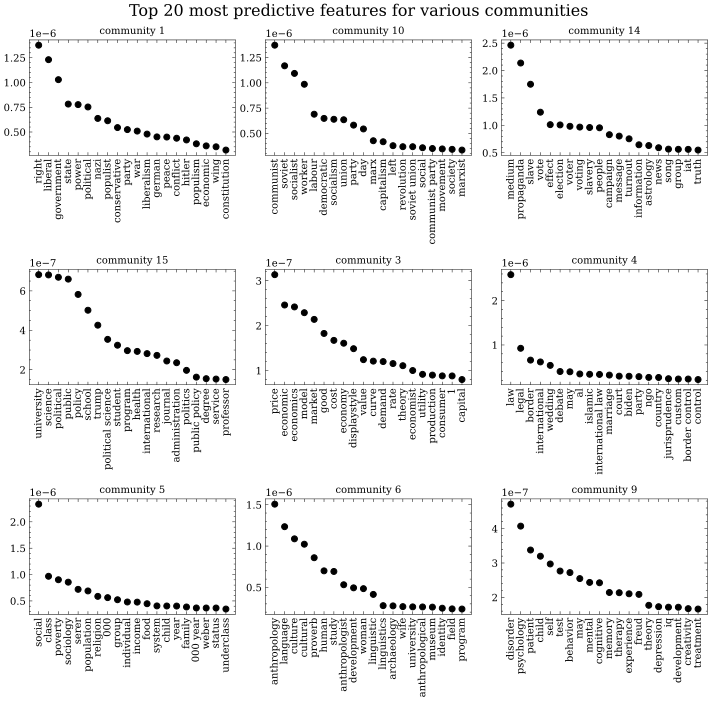

In [8]:
# We fit the multinomial_logit_margins() on our raw counts and plot our results
margins_pd = multinomial_logit_margins()
most_predictive_features = plot_most_predictive_features(margins_pd)

Before we comment features' meaning it is important to notice that the y-scale uses scientific notation and thus reflect quite small effect sizes. All though the difference are minor, we believe that the most predictive features from the multinomial logistic regression makes the communities are bit easier to interpret. It now becomes clearer that community 5 is related to sociology and community 4 have something to do with middle-eastern immigration. To see how each of these topic are strucuted and related to the different disciplines we draw each of them as networks which nodes colourd according to their discipline.

In [9]:
%%capture

# Prettifying and uniforming names in the df and graph
def change_node_names(node):
    """
    Replaces "_" to " " in node names.
    """
    return " ".join(node.split("_"))
G = nx.relabel_nodes(G, change_node_names)
df["title"] = df["title"].apply(lambda x: " ".join(x.split("_")))

# Setting colours
def get_colors_palette_from_parent(G: nx.Graph) -> dict:
    """
    Creates a color palette given the parent attributes of the 
    nodes in a network.
    """
    disciplines = set([G.nodes[node]["parent"] for node in G.nodes()])
    col_pal = palettes.viridis(len(disciplines))
    col_pal = {parent: col_pal[key] for key, parent in enumerate(disciplines)}
    return col_pal

col_pal = get_colors_palette_from_parent(G)

def get_color_list_from_palette(G: nx.Graph, col_pal: dict=col_pal) -> list:
    """
    Creates a list of colors given the parent attribute of a node
    and its color defined in the color palette.
    """
    return [col_pal[G.nodes[i]["parent"]] for i in G.nodes]

# Creates dictionary of supgraphs for each community
community_graphs = {}
for c in top9_df.index.tolist():
    community_nodes = [x for x, y in G.nodes(data=True) 
                       if x in df[df["Louvain_Community"] == c]["title"].tolist()]
    community_graphs[c] = G.subgraph(community_nodes)
    
# Specifies positioning algorithm
forceatlas2 = ForceAtlas2(gravity=1)

In [10]:
%%capture
# Create and store a graph plot for each community
graphs = {}
for i, k in enumerate(community_graphs.keys()):
    G = community_graphs[k]
    title = f'Community: {k.split("_")[1]}'
    HOVER_TOOLTIPS = [("Page", "@index"),
                      ("Discipline", "@parent")]
    
    #Create a plot
    graphs[k] = figure(tooltips = HOVER_TOOLTIPS,
                  width=333, plot_height=333,
                  tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom', 
                  x_range=Range1d(-250, 250),
                  y_range=Range1d(-250, 250))
    
    # Add title and subtitle
    graphs[k].add_layout(Title(text= f'{most_predictive_features[k][0:5]}', text_font_style="italic"), 'above')
    graphs[k].add_layout(Title(text=f'Community: {k.split("_")[1]}', text_font_size="16pt"), 'above')
    
    # Hide grid and axs
    graphs[k].axis.visible = False
    graphs[k].grid.grid_line_color = None
    
    #Set positions, node size and color
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    G_interactive = from_networkx(G, positions, scale=1, center=(0, 0))
    G_interactive.node_renderer.data_source.data['node_sizes'] = [G.degree(node) * 0.25 for node in tqdm(G.nodes())]
    G_interactive.node_renderer.data_source.data['node_colour'] = get_color_list_from_palette(G)
    G_interactive.node_renderer.data_source.data['alpha'] = [0.75 for node in G.nodes()]
    G_interactive.node_renderer.glyph = Circle(
        size="node_sizes",
        fill_color="node_colour",
        fill_alpha = "alpha")
    
    #Set edge opacity and width
    G_interactive.edge_renderer.glyph = MultiLine(line_alpha=0.8, line_width=0.1)
    graphs[k].renderers.append(G_interactive)

In [11]:
# Plot the graphs
show(row(graphs["community_1"], graphs["community_10"], graphs["community_14"]))
show(row(graphs["community_15"], graphs["community_3"], graphs["community_4"]))
show(row(graphs["community_5"], graphs["community_6"], graphs["community_9"]))

These graphs highlight that the main communites - using the Louvain algorithm - of our network are very much intra-disciplinary. There is however two exceptions: Community 14 and 5. Whereas community 14 is a bit of a mixture of all bad things such as [propaganda](https://en.wikipedia.org/wiki/Propaganda), [slave](https://en.wikipedia.org/wiki/Slave), [brainwashing](https://en.wikipedia.org/wiki/Brainwashing), [peer pressure](https://en.wikipedia.org/wiki/Peer_pressure) and [astrology](https://en.wikipedia.org/wiki/Astrology), community 5 seems to constitute anthropology and sociology's view on a society's vital components such [religion](https://en.wikipedia.org/wiki/Religion), [language](https://en.wikipedia.org/wiki/language), [classes](https://en.wikipedia.org/wiki/Social_class) and [social complexity](https://en.wikipedia.org/wiki/Social_complexity). 

In [12]:
"""
# If we want to bootstrap ci
def bootstrap_ci(tf=tf, n_prop:int=0.50, n_runs:int=100):
    statistics = [] 
    n_obs = tf.values.shape[1]
    n_size = int(n_obs * n_prop)
    print(f"Number of obs in bootstrap samples {n_size}...")
    start = time.time()
    for i in tqdm(range(n_runs)):
        #Draw random sample from X and y with replacement
        sample = tf.sample(n=n_size,axis='columns')
        x_sample = sample.values
        y_sample = sample.index.values
        #Calculate marginal effect for sample
        m = margins(x_sample, y_sample, vocab = sample.columns.tolist())
        statistics.append(m)

    #Join the resulting dataframes of margins
    statistics = pd.concat(statistics, axis=0)
    print(f"Boostraping Done. Calculating {1-0.05}% confidence interval...")
    #From bootstrap results get lower and upper CI limits based on alpha
    statistics = statistics.groupby("token").quantile([0.05, 1-0.05]).reset_index()    
    print("Time to complete: ", time.time() - start)
    return statistics
    
margins_pd = margins()
std = bootstrap_ci()
"""

'\n# If we want to bootstrap ci\ndef bootstrap_ci(tf=tf, n_prop:int=0.50, n_runs:int=100):\n    statistics = [] \n    n_obs = tf.values.shape[1]\n    n_size = int(n_obs * n_prop)\n    print(f"Number of obs in bootstrap samples {n_size}...")\n    start = time.time()\n    for i in tqdm(range(n_runs)):\n        #Draw random sample from X and y with replacement\n        sample = tf.sample(n=n_size,axis=\'columns\')\n        x_sample = sample.values\n        y_sample = sample.index.values\n        #Calculate marginal effect for sample\n        m = margins(x_sample, y_sample, vocab = sample.columns.tolist())\n        statistics.append(m)\n\n    #Join the resulting dataframes of margins\n    statistics = pd.concat(statistics, axis=0)\n    print(f"Boostraping Done. Calculating {1-0.05}% confidence interval...")\n    #From bootstrap results get lower and upper CI limits based on alpha\n    statistics = statistics.groupby("token").quantile([0.05, 1-0.05]).reset_index()    \n    print("Time to co